# NLP Project 2024 - Dataset summary
This is the final course project for the NLP (Natural Language Processing) course, taught by Mark Carman in Politecnico
di Milano (spring 2024). The chosen dataset is the [Medical Meadow Medical Flashcards](https://huggingface.co/datasets/medalpaca/medical_meadow_medical_flashcards).



This dataset is part of a collection of datasets called Medical Meadow, created by [Han et al., 2023](https://arxiv.org/pdf/2304.08247.pdf) for fine-tuning LLM models on question answering tasks and evaluating corresponding performances.

## 0) Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My Drive/Colab Notebooks/NLP

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/My Drive/Colab Notebooks/NLP'
/content/drive/My Drive/Colab Notebooks/NLP


In [ ]:
%pip install numpy nltk scikit-learn matplotlib pandas
import os, json
import numpy as np
import nltk
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

## 1) Preliminary Analysis

This dataset comprises a collection of questions coming from an open source list of Anki flashcards (the *Anki Medical Curriculum*), created, mantained and used by medicine students, spanning many subjects, such as anatomy, physiology, pathology, pharmacology,
and more.\
The dataset, due to its use, is mainly composed of short Q&A pairs, usually summarizing very briefly a subject that could be explained in a much more detailed way. This could be a negative aspect for NLP models, because of the lack of content.

### 1.1) Dataset loading

Since the dataset comes in the json format, let's use the ```json``` library to open it.

In [ ]:
with open('medical_meadow_wikidoc_medical_flashcards.json') as f:
    dataset = json.load(f)

df = pd.DataFrame(dataset)

### 1.2) Dataset visualization

Let's visualize how the actual data look like:

In [ ]:
df.head(5)

,instruction,input,output
0,Answer this question truthfully,What is the relationship between very low Mg2+...,Very low Mg2+ levels correspond to low PTH lev...
1,Answer this question truthfully,What leads to genitourinary syndrome of menopa...,Low estradiol production leads to genitourinar...
2,Answer this question truthfully,What does low REM sleep latency and experienci...,Low REM sleep latency and experiencing halluci...
3,Answer this question truthfully,What are some possible causes of low PTH and h...,"PTH-independent hypercalcemia, which can be ca..."
4,Answer this question truthfully,How does the level of anti-müllerian hormone r...,The level of anti-müllerian hormone is directl...


We can notice the structure of the dataset: each json object includes an *input*, that corresponds to the question on the flashcard, and an *output*, which is the corresponding answer. Every datum also includes an *instruction* string which appears to be identical for all the dataset, that simply prescribes to answer truthfully, and it is not of great interest for us:

In [ ]:
np.all([data['instruction'] == 'Answer this question truthfully' for data in dataset])

True

It is indeed identical, hence we can get rid of it:

In [ ]:
df = df[['input', 'output']]
df.head(5)

,input,output
0,What is the relationship between very low Mg2+...,Very low Mg2+ levels correspond to low PTH lev...
1,What leads to genitourinary syndrome of menopa...,Low estradiol production leads to genitourinar...
2,What does low REM sleep latency and experienci...,Low REM sleep latency and experiencing halluci...
3,What are some possible causes of low PTH and h...,"PTH-independent hypercalcemia, which can be ca..."
4,How does the level of anti-müllerian hormone r...,The level of anti-müllerian hormone is directl...


We can see if there are some missing values in the dataset, and, if so, remove them (a question without an answer or an answer without a question):

In [ ]:
df.isin(['']).sum()

input     408
output    402
dtype: int64

Note that these rows are probably corresponding to the flashcards that were including images, as stated in Han et al.:


> In our investigation, we leveraged flashcards as a source to create question-answer
pairs for training purposes. Upon **excluding cards containing images**, we harnessed OpenAI’s GPT-3.5-Turbo to
restructure the cards into coherent, contextually pertinent question-answer pairs.



These are the rows corresponding to missing values:

In [ ]:
df[df['input'].isin([''])]

,input,output
4834,,There seems to be an error in the question and...
10355,,
10371,,
13374,,
13954,,
...,...,...
32992,,
33951,,
33952,,
33953,,


We could remove these Q&A, as they don't seem interesting (they are probably due to errors in inserting values), at least for now.

In [ ]:
df.replace('', np.nan, inplace=True)
df = df.dropna()

Let's see how many question-answer tuples we have in total:

In [ ]:
print(f'Number of question-answer pairs: {len(df)}')

Number of question-answer pairs: 33547


Let's investigate the vocabulary of the Q&As:

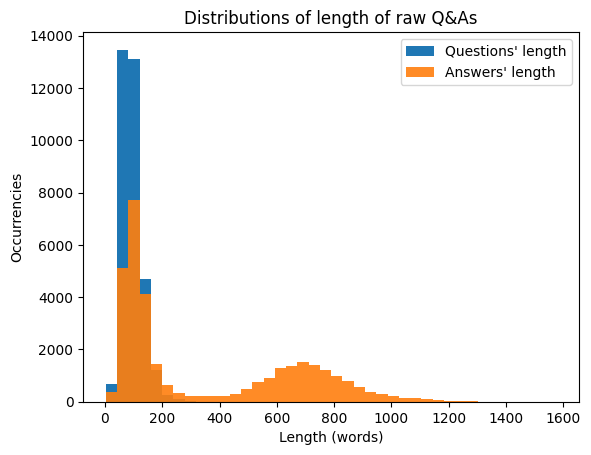

In [ ]:
questions, answers = df['input'], df['output']
len_questions, len_answers = [len(q) for q in questions], [len(a) for a in answers]

bins = np.histogram(np.hstack((len_questions, len_answers)), bins=40)[1] #get the bin edges
plt.hist(len_questions, bins)
plt.hist(len_answers, bins, alpha=.9)
plt.legend(['Questions\' length', 'Answers\' length'])
plt.xlabel('Length (words)')
plt.ylabel('Occurrencies')
plt.title('Distributions of length of raw Q&As')
#plt.savefig('figs/length_distributions.png')
plt.show()

We can notice that the answers' lengths are mainly distributed around two modes, one close to 100 words, and one at around 700 words.

In [ ]:
print(f'Questions vocab size: (min/max/avg/std) {min(len_questions)}/{max(len_questions)}/{np.mean(len_questions):.2f}/{np.std(len_questions):.2f}')
print(f'Answers vocab size:   (min/max/avg/std) {min(len_answers)}/{max(len_answers)}/{np.mean(len_answers):.2f}/{np.std(len_answers):.2f}')

Questions vocab size: (min/max/avg/std) 15/401/93.53/35.02
Answers vocab size:   (min/max/avg/std) 3/1576/353.30/313.09


Let's have a look at what very long and very short questions/answers look like:

In [ ]:
# longest and shortest questions
sorted_questions = sorted(questions, key=lambda q: len(q))
shortest_q, longest_q = sorted_questions[0], sorted_questions[-1]
longest_q, len(longest_q), shortest_q, len(shortest_q)

('What could be the possible diagnosis for a young adult female who presents with symptoms of symmetric, migratory, polyarticular arthritis/arthralgias (inflammation/pain in multiple joints), brief morning stiffness, painless oral ulcers, splenomegaly (enlarged spleen), and laboratory findings of pancytopenia (low counts of all blood cells), RBCs (red blood cells), and proteinuria (protein in urine)?',
 401,
 'What is CDKN2A?',
 15)

In [ ]:
# longest and shortest answers
sorted_answers = sorted(answers, key=lambda q: len(q))
shortest_a, longest_a = sorted_answers[0], sorted_answers[-1]
longest_a, len(longest_a), shortest_a, len(shortest_a)

("Hyperkalemia, or high levels of potassium (K+) in the blood, can cause a prolonged PR interval, loss of the p wave, and wide QRS on ECG.\n\nPotassium is an important electrolyte that plays a role in many physiological processes, including muscle and nerve function, fluid balance, and acid-base balance. However, when there is too much potassium in the blood, it can lead to a variety of symptoms and complications.\n\nHyperkalemia can affect the heart's electrical conduction system, leading to changes on an electrocardiogram (ECG). Specifically, hyperkalemia can cause a prolonged PR interval, which is the time it takes for the electrical signal to travel from the atria to the ventricles. It can also cause loss of the p wave, which is the first wave on the ECG that represents atrial depolarization, and a wide QRS complex, which represents ventricular depolarization.\n\nIn addition to ECG changes, hyperkalemia can cause a range of symptoms, including muscle weakness, paralysis, and cardia

Now, let's employ a ```CountVectorizer``` to get the counts of tokenized vocabulary.

In [ ]:
vocab = questions + answers

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(vocab)
len(vectorizer.get_feature_names_out())

22855

We can also tokenize questions and answers to get a 'clean' dataset; we can then plot the distributions of length of unique tokens for questions and answers, observing a drastic decrease in count values, along with more Gaussian-shaped distributions.

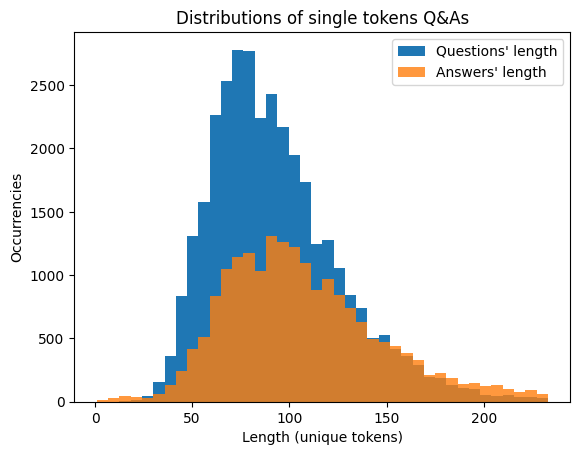

In [ ]:
tokenizer = vectorizer.build_tokenizer()
tokenized_questions = [tokenizer(q) for q in questions]
tokenized_answers = [tokenizer(a) for a in answers]

len_tok_questions, len_tok_answers = [len(q) for q in tokenized_questions], [len(a) for a in tokenized_answers]
bins = np.histogram(np.hstack((len_tok_questions, len_tok_answers)), bins=40)[1] #get the bin edges
plt.hist(len_questions, bins)
plt.hist(len_answers, bins, alpha=.8)
plt.legend(['Questions\' length', 'Answers\' length'])
plt.xlabel('Length (unique tokens)')
plt.ylabel('Occurrencies')
plt.title('Distributions of single tokens Q&As')
#plt.savefig('figs/length_distributions_tokenized.png')
plt.show()

In [ ]:
print(f'Questions vocab size: (min/max/avg/std) {min(len_tok_questions)}/{max(len_tok_questions)}/{np.mean(len_tok_questions):.2f}/{np.std(len_tok_questions):.2f}')
print(f'Answers vocab size:   (min/max/avg/std) {min(len_tok_answers)}/{max(len_tok_answers)}/{np.mean(len_tok_answers):.2f}/{np.std(len_tok_answers):.2f}')

Questions vocab size: (min/max/avg/std) 3/60/14.59/5.50
Answers vocab size:   (min/max/avg/std) 1/233/53.06/47.68


In [ ]:
tokenized_dataset = [{'input': q, 'output': a} for q, a in zip(tokenized_questions, tokenized_answers)]
tokenized_dataset[:3]

[{'input': ['What',
   'is',
   'the',
   'relationship',
   'between',
   'very',
   'low',
   'Mg2',
   'levels',
   'PTH',
   'levels',
   'and',
   'Ca2',
   'levels'],
  'output': ['Very',
   'low',
   'Mg2',
   'levels',
   'correspond',
   'to',
   'low',
   'PTH',
   'levels',
   'which',
   'in',
   'turn',
   'results',
   'in',
   'low',
   'Ca2',
   'levels']},
 {'input': ['What',
   'leads',
   'to',
   'genitourinary',
   'syndrome',
   'of',
   'menopause',
   'atrophic',
   'vaginitis'],
  'output': ['Low',
   'estradiol',
   'production',
   'leads',
   'to',
   'genitourinary',
   'syndrome',
   'of',
   'menopause',
   'atrophic',
   'vaginitis']},
 {'input': ['What',
   'does',
   'low',
   'REM',
   'sleep',
   'latency',
   'and',
   'experiencing',
   'hallucinations',
   'sleep',
   'paralysis',
   'suggest'],
  'output': ['Low',
   'REM',
   'sleep',
   'latency',
   'and',
   'experiencing',
   'hallucinations',
   'sleep',
   'paralysis',
   'suggests',
   'n